In [1]:
elastic_rods_dir = '../../add_params_elastic_rods/python'
weaving_dir = '../'
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt

In [2]:
# Reloadable libraries
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (initialize_linkage, 
                                   update_rest_curvature, 
                                   set_ribbon_linkage)
from compute_curve_from_curvature import (match_geo_curvature_and_edge_len,
                                          get_curve_from_angle,
                                          get_laser_cutting_patter)
from linkage_utils import order_segments_by_strips, get_turning_angle_and_length_from_ordered_rods

### Test order segments by strips has traced all segments

In [3]:
# Squid Parameters
default_camera_parameters = ((2.6356424863754238, -0.4503969385962889, 1.3527994896953035),(-0.0537660776573421, 0.07656413210907485, 0.9956569100687859),(0.12136370840743856, -0.04524672040635298, 0.06655322162019965))
RIBBON_CS = [0.05, 0.5]
ISO_CS = [0.5, 0.5]
MODEL_PATH = osp.join(weaving_dir + 'models/squidward_linkage.obj')
SUBDIVISION_RESOLUTION = 6
with so(): straight_weaver_linkage, straight_weaver_view = initialize_linkage(model_path = MODEL_PATH, cam_param = default_camera_parameters, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION)
strips = order_segments_by_strips(straight_weaver_linkage)
total_num_edges = sum([len(strip) for strip in strips])
assert(total_num_edges == straight_weaver_linkage.numSegments())

### Test compute laser cutting pattern from sphere linkage

In [4]:
# Ground truth result for the sphere linkage
pattern = np.load('ground_truth_sphere_laser_cutting_pattern.npz')
top_x = pattern['top_x']
top_y = pattern['top_y']
bottom_x = pattern['bottom_x']
bottom_y = pattern['bottom_y']
joints_xs = pattern['joints_xs']
joints_ys = pattern['joints_ys']
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
plt.gcf().subplots_adjust(0,0,1,1)
ax.set_aspect('equal')
ax.axis('off')
plt.plot(top_x, top_y, '-', label='shifted up', linewidth = 0.1)
plt.plot(bottom_x, bottom_y, '-', label='shifted down', linewidth = 0.1)
plt.scatter(joints_xs, joints_ys, s = 0.3, facecolors='none', edgecolors='black')
plt.show()

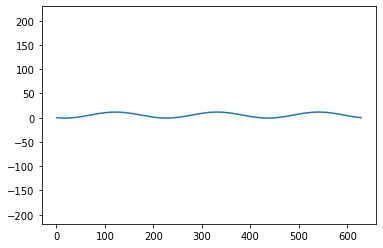

In [5]:
# Current result for the sphere linkage
linkage_descriptions = np.load('free_linkage_strip_angle_edge_len.npz')
strips = linkage_descriptions['strips']
all_strip_angle = linkage_descriptions['all_strip_angle']
all_strip_edge_len = linkage_descriptions['all_strip_edge_len']
top_x, top_y, bottom_x, bottom_y, joints_xs, joints_ys = get_laser_cutting_patter(strips, all_strip_angle, all_strip_edge_len)